In [1]:
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from examples.models.initializer import initialize_torchvision_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

import suitability.filter.tests as ftests
from suitability.datasets.wilds import get_wilds_dataset
from suitability.filter.sample_signals import (
    ConfidenceSignal,
    CorrectnessSignal,
    DecisionBoundarySignal,
    LogitSignal,
    TrainingDynamicsSignal,
)

# importlib.reload(ftests)

random.seed(32)
np.random.seed(32)

In [2]:
def remove_prefix_from_state_dict(state_dict, prefix="model."):
    """
    Remove the prefix from the keys in state_dict if it exists.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix) :]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

## Train Regressor

In [3]:
root_dir = "/mfsnic/u/apouget/data/"
dataset_name = "fmow"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = initialize_torchvision_model("densenet121", d_out=62, pretrained=True)
state_dict = remove_prefix_from_state_dict(
    torch.load(
        f"/mfsnic/u/apouget/experiments/{dataset_name}/{dataset_name}_seed:0_epoch:last_model.pth"
    )["algorithm"]
)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

tuning_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
)

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
corr_signal = CorrectnessSignal(model, device)
corr = corr_signal.evaluate(tuning_data)

conf_mean_signal = ConfidenceSignal(model, device)
conf_mean = conf_mean_signal.evaluate(tuning_data, "mean")
conf_max_signal = ConfidenceSignal(model, device)
conf_max = conf_max_signal.evaluate(tuning_data, "max")
conf_std_signal = ConfidenceSignal(model, device)
conf_std = conf_std_signal.evaluate(tuning_data, "std")

logit_mean_signal = LogitSignal(model, device)
logit_mean = logit_mean_signal.evaluate(tuning_data, "mean")
logit_max_signal = LogitSignal(model, device)
logit_max = logit_max_signal.evaluate(tuning_data, "max")
logit_std_signal = LogitSignal(model, device)
logit_std = logit_std_signal.evaluate(tuning_data, "std")

In [5]:
labels = corr
features = np.column_stack(
    (conf_mean, conf_max, conf_std, logit_mean, logit_max, logit_std)
)

# Split data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Initialize the logistic regression model
regression_model = LogisticRegression()

# Train the model
regression_model.fit(X_train, y_train)

# Predict probabilities on the test set (probability of label being 1)
y_pred_prob = regression_model.predict_proba(X_test)[:, 1]  # Get the probability for class 1

# Evaluate model performance (accuracy, AUC)
accuracy = accuracy_score(y_test, regression_model.predict(X_test))
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUC Score: {auc_score:.2f}")

Accuracy: 0.77
AUC Score: 0.84


In [6]:
print(regression_model.coef_)

[[ 0.01126965  0.53624409  0.07029164 -0.11657969  0.30686658 -0.82704263]]


## Hypothesis Test (Region)

In [7]:
# Determine data splits
REGIONS = ["Asia", "Europe", "Africa", "Americas", "Oceania"]

# Construct suitability filter
max_confidences = {}
mean_confidences = {}
std_confidences = {}
max_logits = {}
mean_logits = {}
std_logits = {}
correctness = {}

for region in REGIONS:
    data = get_wilds_dataset(
        dataset_name,
        root_dir,
        "test",
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pre_filter={"region": region},
    )

    max_conf_signal = ConfidenceSignal(model, device)
    max_confidences[region] = max_conf_signal.evaluate(data, "max")
    mean_conf_signal = ConfidenceSignal(model, device)
    mean_confidences[region] = mean_conf_signal.evaluate(data, "mean")
    std_conf_signal = ConfidenceSignal(model, device)
    std_confidences[region] = std_conf_signal.evaluate(data, "std")

    max_logit_signal = LogitSignal(model, device)
    max_logits[region] = max_logit_signal.evaluate(data, "max")
    mean_logit_signal = LogitSignal(model, device)
    mean_logits[region] = mean_logit_signal.evaluate(data, "mean")
    std_logit_signal = LogitSignal(model, device)
    std_logits[region] = std_logit_signal.evaluate(data, "std")

    corr_signal = CorrectnessSignal(model, device)
    correctness[region] = corr_signal.evaluate(data)

    print(f"Region {region}: {np.mean(correctness[region]) * 100:.2f}% correct")

Region Asia: 55.35% correct
Region Europe: 56.16% correct
Region Africa: 32.78% correct
Region Americas: 56.72% correct
Region Oceania: 59.46% correct


In [8]:
test_fn = ftests.non_inferiority_ttest

test_country = "Asia"

# Test the suitability filter
bm_features = np.column_stack((mean_confidences[test_country], max_confidences[test_country], std_confidences[test_country], mean_logits[test_country], max_logits[test_country], std_logits[test_country]))
bm_dist = regression_model.predict_proba(bm_features)[:, 1]

for region in REGIONS:
    print(f"Region {region}:")
    reg_features = np.column_stack((mean_confidences[region], max_confidences[region], std_confidences[region], mean_logits[region], max_logits[region], std_logits[region]))
    reg_dist = regression_model.predict_proba(reg_features)[:, 1]
    print(test_fn(bm_dist, reg_dist, margin=0))

Region Asia:
{'t_statistic': 0.0, 'p_value': 0.5, 'reject_null': False}
Region Europe:
{'t_statistic': 0.10714194258314827, 'p_value': 0.5426608091037977, 'reject_null': False}
Region Africa:
{'t_statistic': 15.745534722498704, 'p_value': 1.0, 'reject_null': False}
Region Americas:
{'t_statistic': -2.337889395799582, 'p_value': 0.009705644222248646, 'reject_null': True}
Region Oceania:
{'t_statistic': -2.6109898433017076, 'p_value': 0.004593450617763993, 'reject_null': True}


In [13]:
from statsmodels.stats.power import TTestIndPower

# Create an instance of the power analysis class
analysis = TTestIndPower()

effect_size = (np.mean(reg_dist) - np.mean(bm_dist)) / np.std(bm_dist)

# Perform power analysis
sample_size = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger')
print('Required sample size:', sample_size)


Required sample size: 1054.9202969889313


In [14]:
sample2, sample1 = bm_dist, reg_dist

mean1, mean2 = np.mean(sample1), np.mean(sample2)
std1, std2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
n1, n2 = len(sample1), len(sample2)

pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
effect_size = (mean1 - mean2) / pooled_std

sample_size = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger')
print('Required sample size:', sample_size)

Required sample size: 1056.554464586732


In [32]:
def glass_delta(sample1, sample2, margin, increase_good=True):
    """
    Calculate Glass's delta effect size for two samples.
    sample1: array of values for sample 1 (typically validation data provided by model provider)
    sample2: array of values for sample 2 (typically sample provided by model user)
    margin: non-inferiority margin
    increase_good: if True, Ho: mean2 <= mean1. Else Ho: mean2 >= mean1.
    Returns: Glass's delta effect size
    """
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    std1 = np.std(sample1, ddof=1)

    if increase_good:
        glass_delta = (mean2 - (mean1 - margin)) / std1
    else:
        glass_delta = (mean2 - (mean1 + margin)) / std1

    return glass_delta

def cohen_d(sample1, sample2, margin, increase_good=True):
    """
    Calculate Cohen's d effect size for two samples.
    sample1: array of values for sample 1 (typically validation data provided by model provider)
    sample2: array of values for sample 2 (typically sample provided by model user)
    margin: non-inferiority margin
    increase_good: if True, Ho: mean2 <= mean1. Else Ho: mean2 >= mean1.
    Returns: Cohen's d effect size
    """
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    std1, std2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
    n1, n2 = len(sample1), len(sample2)

    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    if increase_good:
        cohens_d = (mean2 - (mean1 - margin)) / pooled_std
    else:
        cohens_d = (mean2 - (mean1 + margin)) / pooled_std

    return cohens_d

def sample_size_non_inferiority_ttest(
    sample1, sample2, power, margin=0, increase_good=True, alpha=0.05, effect_method="cohen"
):
    """
    Calculate the required sample size for a given power level.
    sample1: array of values for sample 1 (typically validation data provided by model provider)
    sample2: array of values for sample 2 (typically sample provided by model user)
    power: desired power level (probability of rejecting the null hypothesis when it is false)
    margin: non-inferiority margin
    increase_good: if True, Ho: mean2 <= mean1. Else Ho: mean2 >= mean1.
    alpha: significance level
    effect_method: method to calculate effect size. Options: "cohen" or "glass"
    Returns: required sample size for sample2
    """
    if effect_method == "cohen":
        effect_size = cohen_d(sample1, sample2, margin, increase_good)
    elif effect_method == "glass":
        effect_size = glass_delta(sample1, sample2, margin, increase_good)
    else:
        raise ValueError("Invalid effect size method.")

    if abs(effect_size) < 1e-6:
        raise ValueError("Effect size too small for power analysis.")

    analysis = TTestIndPower()

    ratio = analysis.solve_power(
        effect_size=effect_size,
        nobs1=len(sample1),
        alpha=alpha,
        power=power,
        alternative="larger" if increase_good else "smaller",
        ratio=None,
    )

    return int(np.ceil(len(sample1)*ratio))

def power_non_inferiority_ttest(sample1, sample2, margin=0, alpha=0.05, increase_good=True, effect_method="cohen"):
    """
    Calculate the power of a non-inferiority t-test.
    sample1: array of values for sample 1 (typically validation data provided by model provider)
    sample2: array of values for sample 2 (typically sample provided by model user)
    margin: non-inferiority margin
    alpha: significance level
    increase_good: if True, Ho: mean2 <= mean1. Else Ho: mean2 >= mean1.
    effect_method: method to calculate effect size. Options: "cohen" or "glass"
    Returns: power of the non-inferiority t-test
    """
    if effect_method == "cohen":
        effect_size = cohen_d(sample1, sample2, margin, increase_good)
    elif effect_method == "glass":
        effect_size = glass_delta(sample1, sample2, margin, increase_good)
    else:
        raise ValueError("Invalid effect size method.")

    if abs(effect_size) < 1e-6:
        raise ValueError("Effect size too small for power analysis.")

    analysis = TTestIndPower()

    power = analysis.solve_power(
        effect_size=effect_size,
        nobs1=len(sample1),
        alpha=alpha,
        alternative="larger" if increase_good else "smaller",
        ratio=len(sample2) / len(sample1),
    )

    return power

In [33]:
sample_size_non_inferiority_ttest(bm_dist, reg_dist, 0.8, increase_good=True, effect_method="cohen")

591

In [34]:
power_non_inferiority_ttest(bm_dist, reg_dist, margin=0, alpha=0.05, increase_good=True, effect_method="cohen")

0.8357532193588865

## Hypothesis Test (Accuracy)

In [22]:
data = get_wilds_dataset(
    dataset_name, root_dir, "test", batch_size=64, shuffle=False, num_workers=4
)

max_conf_signal = ConfidenceSignal(model, device)
max_confidences = max_conf_signal.evaluate(data, "max")
mean_conf_signal = ConfidenceSignal(model, device)
mean_confidences = mean_conf_signal.evaluate(data, "mean")
std_conf_signal = ConfidenceSignal(model, device)
std_confidences = std_conf_signal.evaluate(data, "std")

max_logit_signal = LogitSignal(model, device)
max_logits = max_logit_signal.evaluate(data, "max")
mean_logit_signal = LogitSignal(model, device)
mean_logits = mean_logit_signal.evaluate(data, "mean")
std_logit_signal = LogitSignal(model, device)
std_logits = std_logit_signal.evaluate(data, "std")

corr_signal = CorrectnessSignal(model, device)
correctness = corr_signal.evaluate(data)

In [28]:
def evaluate_suitability_fmow(n_subsets):
    # Number of subsets and target accuracies
    target_accuracies = np.linspace(0.3, 0.75, n_subsets)
    total_samples = len(correctness)

    # Shuffle the data to randomize distribution
    indices = np.random.permutation(total_samples)
    shuffled_correctness = correctness[indices]
    shuffled_mean_confidences = mean_confidences[indices]
    shuffled_max_confidences = max_confidences[indices]
    shuffled_std_confidences = std_confidences[indices]
    shuffled_mean_logits = mean_logits[indices]
    shuffled_max_logits = max_logits[indices]
    shuffled_std_logits = std_logits[indices]

    # Create subsets with specific accuracies
    subsets_regression_mean = [None] * n_subsets
    subsets_p_value = [None] * n_subsets
    subset_accuracies = [None] * n_subsets
    start_idx = 0

    for i, target_accuracy in enumerate(target_accuracies):
        # Calculate the number of correct and incorrect samples needed for the subset
        subset_size = total_samples // n_subsets
        n_correct = int(subset_size * target_accuracy)
        n_incorrect = subset_size - n_correct

        # Find the correct/incorrect samples in the shuffled data
        correct_indices = np.where(shuffled_correctness[start_idx:] == 1)[0][:n_correct]
        incorrect_indices = np.where(shuffled_correctness[start_idx:] == 0)[0][:n_incorrect]

        # Get the final indices for the current subset
        subset_indices = np.concatenate((correct_indices, incorrect_indices)) + start_idx

        # Extract the subset from correctness and logits arrays
        feature = np.column_stack((shuffled_mean_confidences[subset_indices], shuffled_max_confidences[subset_indices], shuffled_std_confidences[subset_indices], shuffled_mean_logits[subset_indices], shuffled_max_logits[subset_indices], shuffled_std_logits[subset_indices]))
        correctness_subset = shuffled_correctness[subset_indices]
        regression_subset = regression_model.predict_proba(feature)[:, 1]

        # Move the start index forward
        start_idx += len(subset_indices)

        # Print the achieved accuracy
        # accuracy = np.mean(subsets_correctness[i])
        # subset_size = len(subset_indices)
        # print(
        #     f"Subset of size {subset_size} with target accuracy {target_accuracy:.2f}: Achieved accuracy = {accuracy:.2f}"
        # )

        subsets_regression_mean[i] = np.mean(regression_subset)
        subsets_p_value[i] = test_fn(bm_dist, regression_subset, margin=0)['p_value']
        subset_accuracies[i] = np.mean(correctness_subset)

    return subsets_regression_mean, subsets_p_value, subset_accuracies

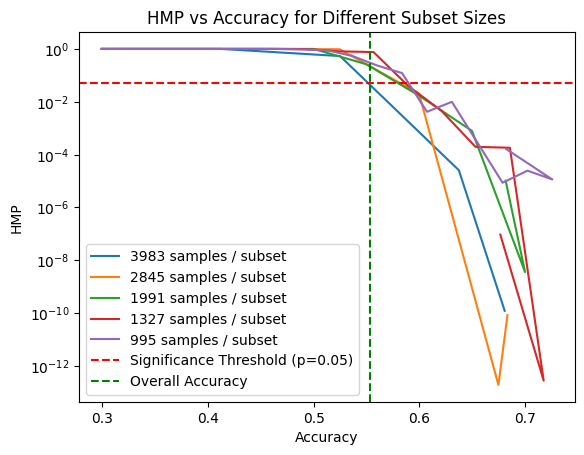

In [30]:
subset_cnt = [5, 7, 10, 15, 20]
test_fn = ftests.non_inferiority_ttest

for cnt in subset_cnt:
    subsets_regression_mean, subsets_p_value, subset_accuracies = evaluate_suitability_fmow(cnt)
    plt.plot(subset_accuracies, subsets_p_value, label=f"{len(corr)//cnt} samples / subset")

plt.xlabel("Accuracy")
plt.ylabel("HMP")
plt.yscale("log")
plt.axhline(
    y=0.05, color="red", linestyle="--", label="Significance Threshold (p=0.05)"
)
plt.axvline(
    x=0.553, color="green", linestyle="--", label="Overall Accuracy"
)
plt.title("HMP vs Accuracy for Different Subset Sizes")
plt.legend()
plt.show()